In [2]:
using Pipe
using Iterators
using DataStructures

In [3]:
function loadphrases(filename)
    (@pipe readall(filename) |> split(_,'\n'))[1:end-1];
end

function load_phrases_and_embeddings(base_filename)
    phrases = loadphrases(base_filename * ".phrases.txt")
    ps = readcsv(base_filename * ".csv")
    @assert size(ps,1)==length(phrases)
    phrases,ps
end

load_phrases_and_embeddings (generic function with 1 method)

In [4]:
#phrase_range = 14380:16000  #old testerment14380:40069
#ps = readcsv("results/gutten.csv")[phrase_range,:]
#phrases = loadphrases("results/gutten.phrases.txt") [phrase_range]

In [17]:
phrases,ps = load_phrases_and_embeddings("results/wikipedia_turtle")

(SubString{ASCIIString}["turtles are *UNKNOWN* of the order *UNKNOWN* *UNKNOWN* or *UNKNOWN*","turtle , *UNKNOWN* or *UNKNOWN*","the word *UNKNOWN* is popular among *UNKNOWN* , scientists , and conservationists working with these animals as a catch-all name for any member of the *UNKNOWN* *UNKNOWN* , which includes all turtles living and *UNKNOWN* , as well as their immediate ancestors .","anatomy and *UNKNOWN* largest living *UNKNOWN* is the *UNKNOWN* sea turtle *UNKNOWN* *UNKNOWN* *UNKNOWN* *UNKNOWN* , which reaches a shell length of","giant *UNKNOWN* of the *UNKNOWN* *UNKNOWN* , *UNKNOWN* , and others were relatively widely distributed around the world into prehistoric times , and are known to have existed in north and south *UNKNOWN* , *UNKNOWN* , and *UNKNOWN* .","they became *UNKNOWN* at the same time as the appearance of man , and it is assumed humans hunted them for food .","the only surviving giant *UNKNOWN* are on the *UNKNOWN* and *UNKNOWN* islands , and can grow to over","n

In [6]:
using PyCall
@pyimport sklearn
@pyimport sklearn.mixture as sklm

In [11]:
gmm=sklm.GMM(n_components=10, covariance_type="full", n_init=25) 
gmm[:fit](ps)
gmm[:weights_]'


1x10 Array{Number,2}:
 0.097561  0.115854  0.128049  0.103659  …  0.134146  0.0762195  0.0884146

In [16]:
ENV["LINES"]=1000
keys(gmm) |> collect

47-element Array{Any,1}:
 :__class__       
 :__delattr__     
 :__dict__        
 :__doc__         
 :__format__      
 :__getattribute__
 :__hash__        
 :__init__        
 :__module__      
 :__new__         
 :__reduce__      
 :__reduce_ex__   
 :__repr__        
 :__setattr__     
 :__sizeof__      
 :__str__         
 :__subclasshook__
 :__weakref__     
 :_do_mstep       
 :_get_covars     
 :_get_param_names
 :_n_parameters   
 :_set_covars     
 :aic             
 :bic             
 :converged_      
 :covariance_type 
 :covars_         
 :eval            
 :fit             
 :get_params      
 :init_params     
 :means_          
 :min_covar       
 :n_components    
 :n_init          
 :n_iter          
 :params          
 :predict         
 :predict_proba   
 :random_state    
 :sample          
 :score           
 :score_samples   
 :set_params      
 :thresh          
 :weights_        

In [12]:
function show_clusters_gmm(gmm,xs, words)
    scores = gmm[:score](xs)
    order = sort([1:length(scores);], by=ii->scores[ii], rev=true)
    clusters = DefaultDict(Int, Vector{String}, ()->String[])
    for ii in order
        word = words[ii]
        cluster =  gmm[:predict](xs[ii,:])[1]
        push!(clusters[cluster], word)
    end
    
    for cluster in keys(clusters)
        println("** $cluster **")
        for word in clusters[cluster]
            println(" - ", word)
        end
        println()
    end
    clusters
end
clusters = show_clusters_gmm(gmm, ps, phrases)

** 7 **
 - the battery life is incredible .
 - the battery life is incredible .
 - the battery life is quite extensive .
 - the battery life is unbelievable , even while using *UNKNOWN* to transfer files , watching movies and surfing the internet with screen *UNKNOWN* all the way up .
 - the battery life has been amazing so far .
 - the battery life is as advertised .
 - the battery life is as advertised here .
 - the battery life is plenty for me .
 - the battery life is not its promised 10 .
 - the battery life is excellent , with normal usage i can get about 7 hours easily , more if i turn off *UNKNOWN* and turn down the screen *UNKNOWN* .
 - the battery life is amazing .
 - the battery life has not been tested in one complete sitting .
 - the battery life has been very good , especially if you follow the rule of turning off the wireless and *UNKNOWN* , and turning down the screen *UNKNOWN* .
 - the battery power is as advertised which is a main reason i selected this *UNKNOWN* .
 -

DefaultDict{Int64,Array{String,1},Function} with 10 entries:
  7 => String["the battery life is incredible .","the battery life is incredibl…
  9 => String["i needed something comfortable for typing documents plus somethi…
  4 => String["5 hour battery , *UNKNOWN* display","5 hour battery , *UNKNOWN* …
  0 => String["i actually went without charging it for more than a day because …
  2 => String["i expected six or seven hours in reality , , i 'm aware that bat…
  3 => String["and the battery last only about 7 hours of normal use .","now i …
  8 => String["battery life is longer than i had expected obviously 10 .","5 ho…
  5 => String["2 fail , after three charge cycles , the *UNKNOWN* *UNKNOWN* ble…
  6 => String["i have n't done a real battery test , but i can tell you that it…
  1 => String["it has the fastest processor currently available , huge battery …

In [7]:
@pyimport sklearn.cluster as skl_cluster

In [145]:
bandwidth = skl_cluster.estimate_bandwidth(ps, quantile=0.05)
ms = skl_cluster.MeanShift(bandwidth=bandwidth, bin_seeding=false, min_bin_freq=1)

println(ms[:fit](ps))
println( ms[:labels_] |> unique |> sort)

PyObject MeanShift(bandwidth=1.03613481666, bin_seeding=False, cluster_all=True,
     min_bin_freq=1, seeds=None)
[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56]


In [146]:
function show_clusters(model,words, labels)
    clusters = DefaultDict(Int, Vector{String}, ()->String[])
    for ii in 1:length(words)
        word = words[ii]
        cluster =  labels[ii]
        push!(clusters[cluster], word)
    end
    
    for cluster in keys(clusters)
        println("** $cluster **")
        for word in clusters[cluster]
            println(" - ", word)
        end
        println()
    end
    clusters
end

show_clusters(ms,phrases, ms[:labels_])

** 2 **
 - family *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN*

** 11 **
 - neck withdrawal

** 39 **
 - diet
 - notes

** 46 **
 - new scientist article *UNKNOWN* including video *UNKNOWN* on how the turtle evolved its shell

** 25 **
 - they became *UNKNOWN* at the same time as the appearance of man , and it is assumed humans hunted them for food .

** 55 **
 - anatomy and *UNKNOWN* largest living *UNKNOWN* is the *UNKNOWN* sea turtle *UNKNOWN* *UNKNOWN* *UNKNOWN* *UNKNOWN* , which reaches a shell length of

** 42 **
 - *UNKNOWN* respiration in *UNKNOWN* *UNKNOWN* turtles is currently being studied .

** 29 **
 - the flesh of

DefaultDict{Int64,Array{String,1},Function} with 57 entries:
  2  => String["family *UNKNOWN* *UNKNOWN*","family *UNKNOWN* *UNKNOWN*","famil…
  11 => String["neck withdrawal"]
  39 => String["diet","notes"]
  46 => String["new scientist article *UNKNOWN* including video *UNKNOWN* on ho…
  25 => String["they became *UNKNOWN* at the same time as the appearance of man…
  55 => String["anatomy and *UNKNOWN* largest living *UNKNOWN* is the *UNKNOWN*…
  42 => String["*UNKNOWN* respiration in *UNKNOWN* *UNKNOWN* turtles is current…
  29 => String["the flesh of turtles , *UNKNOWN* or *UNKNOWN* , was , and still…
  8  => String["of the 263 species of *UNKNOWN* and *UNKNOWN* turtles , 117 spe…
  20 => String["some land turtles have very poor pursuit movement abilities , w…
  14 => String["giant *UNKNOWN* of the *UNKNOWN* *UNKNOWN* , *UNKNOWN* , and ot…
  31 => String["sea turtles fly through the water , using the up-and-down motio…
  52 => String["amphibious turtles normally have limbs similar t

In [8]:
using Distances
push!(LOAD_PATH, "../word-embeddings2")
import WordEmbeddings.cosine_sim

In [152]:
pps = ps'
cosine_sim = Number[WordEmbeddings.cosine_sim(pps[:,ii],pps[:,jj]) for ii in 1:size(pps,2), jj in 1:size(pps,2)];
#dot_sim = -1*Number[dot(pps[:,ii],pps[:,jj]) for ii in 1:size(pps,2), jj in 1:size(pps,2)];
#cosine_sim2 = -pairwise(CosineDist(),pps)
manhatten_sim = - pairwise(Cityblock(), pps)
euclidean_sim = -pairwise(Euclidean(),pps)


160x160 Array{Number,2}:
 -0.0      -1.03861  -1.74745  -2.06482  …  -2.15591  -2.20866  -1.9741 
 -1.03861  -0.0      -1.72817  -2.16992     -1.9595   -2.08557  -1.9976 
 -1.74745  -1.72817  -0.0      -2.03791     -2.04634  -2.16462  -1.93626
 -2.06482  -2.16992  -2.03791  -0.0         -2.19767  -2.44167  -2.10814
 -2.00481  -2.12638  -1.7376   -1.98383     -2.29139  -2.59672  -1.9282 
 -1.80171  -1.77688  -1.81901  -1.77482  …  -2.05231  -2.34705  -1.98151
 -2.00575  -2.01355  -1.62116  -2.06746     -2.17749  -2.59976  -1.96337
 -1.40238  -1.39949  -1.61235  -1.85204     -1.86654  -2.09602  -1.69894
 -1.40799  -1.63285  -1.13625  -1.80027     -2.02976  -2.27582  -1.85583
 -2.05441  -1.94735  -1.56811  -2.28029     -2.10497  -2.5883   -1.81023
 -1.67415  -1.66154  -1.60704  -1.74396  …  -1.80596  -2.08306  -1.50719
 -1.68783  -1.84139  -1.40998  -1.81086     -1.94342  -2.29618  -1.75296
 -1.77706  -1.85598  -1.51957  -1.90817     -2.09028  -2.21796  -1.82539
  ⋮                       

In [166]:
#@pipe manhatten_sim |> find(_.==0.0) |> map(ii->ind2sub(size(manhatten_sim),ii), _) |> map(println,_);

In [167]:
affinity = pycall(pybuiltin("intern"),PyObject, "precomputed")
affprop = skl_cluster.AffinityPropagation(damping=0.6,affinity=affinity)

affprop[:fit_predict](manhatten_sim)
centers = affprop[:cluster_centers_indices_] + 1 #julia indexing
for phrase in phrases[centers]
    println(phrase)
end

turtles are *UNKNOWN* of the order *UNKNOWN* *UNKNOWN* or *UNKNOWN*
*UNKNOWN* turtles have *UNKNOWN* ridges that help them cut through tough plants .
the inner layer of a turtle 's shell is made up of about 60 bones that include portions of the backbone and the ribs , meaning the turtle can not crawl out of its shell .
most *UNKNOWN* have a large , *UNKNOWN* shell that makes it difficult for predators to crush the shell between their *UNKNOWN* .
in some species , shells may have red , orange , yellow , or gray markings , often spots , lines , or irregular blotches .
one of the most colorful turtles is the eastern painted turtle , which includes a yellow *UNKNOWN* and a black or olive shell with red markings around the rim . *UNKNOWN* , being land-based , have rather heavy shells .
*UNKNOWN* are famous for moving slowly , in part because of their heavy , cumbersome shells , which restrict stride length .
these turtles swim using all four feet in a way similar to the dog *UNKNOWN* , with

In [168]:
show_clusters(affprop,phrases, affprop[:labels_])

** 18 **
 - family *UNKNOWN* *UNKNOWN* *UNKNOWN* *UNKNOWN* and *UNKNOWN* *UNKNOWN* river turtles *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN* snapping turtles *UNKNOWN*
 - *UNKNOWN* *UNKNOWN* *UNKNOWN* sea turtles *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN* green sea turtles and relatives *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN* pond , box , and water turtles *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN* *UNKNOWN* river turtles , *UNKNOWN* leaf turtles , *UNKNOWN* box turtles , and *UNKNOWN* turtles *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN* true *UNKNOWN* *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN* river turtles *UNKNOWN*
 - family *UNKNOWN* *UNKNOWN* mud turtles *UNKNOWN*

** 2 **
 - the word *UNKNOWN* is popular among *UNKNOWN* , scientists , and conservationists working with these animals as a catch-all name for any member of the *UNKNOWN* *UNKNOWN* , which includes all turtles living and *UNKNOWN* , as well as their immediate ancestors .
 - the upper shell of the turtle is called the *UNKNOWN* .
 - the 

DefaultDict{Int64,Array{String,1},Function} with 23 entries:
  18 => String["family *UNKNOWN* *UNKNOWN* *UNKNOWN* *UNKNOWN* and *UNKNOWN* *U…
  2  => String["the word *UNKNOWN* is popular among *UNKNOWN* , scientists , an…
  16 => String["*UNKNOWN* *UNKNOWN* *UNKNOWN*","*UNKNOWN* *UNKNOWN* *UNKNOWN*",…
  11 => String["some *UNKNOWN* turtles , such as snapping turtles and *UNKNOWN*…
  21 => String["giant *UNKNOWN* of the *UNKNOWN* *UNKNOWN* , *UNKNOWN* , and ot…
  0  => String["turtles are *UNKNOWN* of the order *UNKNOWN* *UNKNOWN* or *UNKN…
  9  => String["the only surviving giant *UNKNOWN* are on the *UNKNOWN* and *UN…
  7  => String["some turtles do not have *UNKNOWN* *UNKNOWN* .","these lighter …
  10 => String["anatomy and *UNKNOWN* largest living *UNKNOWN* is the *UNKNOWN*…
  19 => String["family *UNKNOWN* *UNKNOWN* *UNKNOWN* *UNKNOWN* turtles *UNKNOWN…
  17 => String["*UNKNOWN* *UNKNOWN*","*UNKNOWN* *UNKNOWN*","*UNKNOWN* *UNKNOWN*…
  8  => String["*UNKNOWN* snapping turtles and *

In [95]:
count,index = findmax(clustercounts)
(affprop[:labels_].=62) |> countnz

LoadError: .= not defined
while loading In[95], in expression starting on line 2

In [129]:
cdic = {center=>countnz(affprop[:labels_].==center) for center in (affprop[:labels_] |>unique)}
kcounts =sort(cdic |> collect, by=kc->kc[2])
most_common_cluster0 = kcounts[end-1][1]
phrase_ind0 = affprop[:cluster_centers_indices_][most_common_cluster0]
println("**",phrases[phrase_ind0+1],"**")

phrases_in_common_cluster0 = find([(affprop[:labels_].==most_common_cluster0)])
@pipe phrases[phrases_in_common_cluster0+1] |> map(println,_);

**4 : 12 now therefore go , and i will be with *UNKNOWN* mouth , and teach *UNKNOWN* what *UNKNOWN* shalt say .**
5 : 26 and *UNKNOWN* lived after he *UNKNOWN* *UNKNOWN* seven hundred *UNKNOWN* and two years , and *UNKNOWN* sons and daughters : 5 : 27 and all the days of *UNKNOWN* were nine hundred *UNKNOWN* and nine years : and he died .
7 : 7 and *UNKNOWN* went in , and his sons , and his wife , and his sons ' wives with him , into the *UNKNOWN* , because of the waters of the flood .
9 : 25 and he said , cursed be *UNKNOWN* ; a servant of servants shall he be unto his brethren .
9 : 29 and all the days of *UNKNOWN* were nine hundred and fifty years : and he died .
and the *UNKNOWN* was then in the land .
13 : 5 and lot also , which went with *UNKNOWN* , had flocks , and herds , and tents .
17 : 1 and when *UNKNOWN* was *UNKNOWN* years old and nine , the lord appeared to *UNKNOWN* , and said unto him , i am the almighty god ; walk before me , and be *UNKNOWN* perfect .
17 : 25 and *UN

In [128]:
size(ps)

(1621,100)

"25 : 24 and when her days to be delivered were fulfilled , behold , there were twins in her womb ."

In [111]:
help(maximum)

Base.maximum(itr)

   Returns the largest element in a collection.

Base.maximum(A, dims)

   Compute the maximum value of an array over the given dimensions.


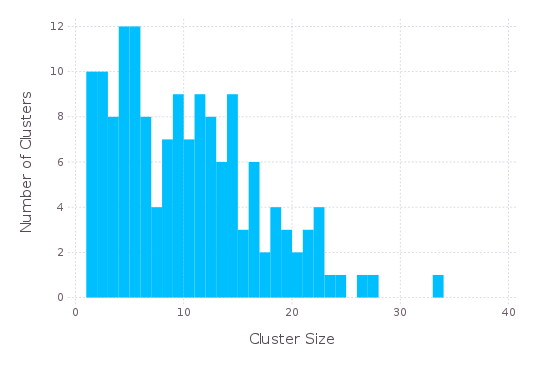

In [88]:
using Gadfly
clustercounts = [countnz(affprop[:labels_].==center) for center in (affprop[:labels_] |>unique)]
plot(x=clustercounts, Geom.histogram, Guide.xlabel("Cluster Size"), Guide.ylabel("Number of Clusters") )

In [ ]:
using Clustering

In [ ]:
affprop_j = affinityprop(similarities, damp=0.25)
#@assert(affprop_j.converged)
for ii in affprop_j.exemplars
    println(phrases[ii])
end

In [ ]:
using MultivariateStats

pca = fit(PCA, ps'; maxoutdim=2)


Y = transform(pca, ps')'


In [ ]:
using TSne
#Y = tsne(ps, no_dims = 2, initial_dims = -1, max_iter = 1000, perplexity = 30.0)
Y = tsne(ps, 10,  -1, 2000, 20.0)

In [ ]:
lbls = zeros(50)
lbls[end-5:end]=1
plot(x=Y[:,1], y=Y[:,2], color=lbls, label=phrases,Geom.point, Geom.label(position=:centered,hide_overlaps=false))

In [ ]:
using Gadfly
set_default_plot_size(20cm, 20cm)